In [1]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from matplotlib.pyplot import figure
import time

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [2]:
def findGroundState(pauliSumOp):
    return min(np.linalg.eigh(pauliSumOp.to_matrix())[0])

#Converts SpinOp to PauliSumOp
def convertSpin(ham):
    result = None
    spins = [I, Z, Y, X]
    for c, x, y, z in zip(ham._coeffs, ham.x, ham.y, ham.z):
        spin = x * 3 + y * 2 + z
        pauli = spins[spin[0]]
        for n in range(1, ham.register_length):
            pauli ^= spins[spin[n]]
        pauli *= c
        result = result + pauli if result else pauli
    return result

def makeLatticeIsing(size):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = 1.0  # the interaction parameter corresponds to Z
    v = 1.0  # the onsite potential corresponds to X

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())

def makeAnsatz(reps = 1, skip = True):
    return TwoLocal(
            rotation_blocks=["rx"],
            entanglement_blocks="rzz",
            entanglement="circular",
            skip_final_rotation_layer = skip,
            reps = reps,
            parameter_prefix="y",)

def findMin(ansatz, reps):
    vqe_solver = VQE(
    ansatz = ansatz,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),)
    
    results = np.full(n, None)
    groundStates = np.full(n, 9999.9)
    times = np.full([n, reps], 0.0)
    for i in range(1, n):
        ising = makeLatticeIsing(i)
        if ising:
            for j in range(reps):
                    result = vqe_solver.compute_minimum_eigenvalue(ising)
                    val = np.real(result.eigenvalue)
                    times[i][j]= result.optimizer_time
                    if val < np.real(groundStates[i]):
                        results[i] = result
                        groundStates[i] = val
                        print(f"Minimum   {i:>2}: {np.round(np.real(result.eigenvalue), 3):<7} " +
                              f"time: {round(result.optimizer_time, 2)}")
                    else:
                        print(f"Processed {i:>2}          time: {round(result.optimizer_time, 2)}")
    return results, groundStates, times

In [3]:
# define maximum size of system
n = 9
#define number of repetitions
r = 10
# define max number of rounds
s = 5

In [4]:
# Find True Groundstates of Model
trueGroundStates = np.full(n, 0.0)
trueTimes = np.full(n, 0.0)
for i in range(1,n):
    t1_start = time.time()
    trueGroundStates[i] = findGroundState(makeLatticeIsing(i))
    trueTimes[i] =  time.time() - t1_start
    print(f"{i:>2}: {round(trueGroundStates[i],3):<7} time: {round(trueTimes[i],3)}")

 1: -1.0    time: 0.003
 2: -2.236  time: 0.004
 3: -3.464  time: 0.007
 4: -5.226  time: 0.01
 5: -6.155  time: 0.014
 6: -7.727  time: 0.018
 7: -8.763  time: 0.029
 8: -10.252 time: 0.037


In [5]:
results = [None] * s
groundStates = [None] * s
times = [None] * s

In [6]:
for i in range(s):
    print(f"rounds = {i + 1}:")
    ansatz = makeAnsatz(reps = i + 1)
    results[i], groundStates[i], times[i] = findMin(ansatz, r)

rounds = 1:
Minimum    1: 0.0     time: 0.29
Processed  1          time: 0.03
Processed  1          time: 0.03
Processed  1          time: 0.02
Processed  1          time: 0.03
Processed  1          time: 0.03
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Minimum    2: -1.618  time: 0.23
Processed  2          time: 0.11
Processed  2          time: 0.19
Processed  2          time: 0.21
Processed  2          time: 0.2
Minimum    2: -1.618  time: 0.17
Minimum    2: -1.618  time: 0.23
Processed  2          time: 0.19
Processed  2          time: 0.17
Processed  2          time: 0.12
Minimum    3: -2.484  time: 0.5
Processed  3          time: 0.69
Processed  3          time: 0.39
Processed  3          time: 0.69
Processed  3          time: 0.43
Processed  3          time: 0.63
Processed  3          time: 0.57
Processed  3          time: 0.94
Processed  3          time: 0.43
Processed  3          time: 0.54


Processed  1          time: 0.05
Processed  1          time: 0.11
Minimum    2: -1.618  time: 0.84
Minimum    2: -1.618  time: 1.0
Processed  2          time: 0.72
Processed  2          time: 0.88
Processed  2          time: 0.81
Processed  2          time: 0.78
Minimum    2: -1.618  time: 0.7
Processed  2          time: 0.7
Processed  2          time: 0.91
Processed  2          time: 0.92
Minimum    3: -2.732  time: 3.58
Minimum    3: -2.732  time: 3.12
Processed  3          time: 3.57
Processed  3          time: 3.56
Processed  3          time: 3.72
Processed  3          time: 3.28
Processed  3          time: 3.2
Processed  3          time: 3.86
Minimum    3: -2.732  time: 3.64
Processed  3          time: 2.87
Minimum    4: -5.027  time: 22.78
Processed  4          time: 22.27
Processed  4          time: 23.71
Minimum    4: -5.027  time: 12.38
Minimum    4: -5.027  time: 20.02
Processed  4          time: 20.96
Processed  4          time: 28.96
Minimum    4: -5.027  time: 24.58
Proces

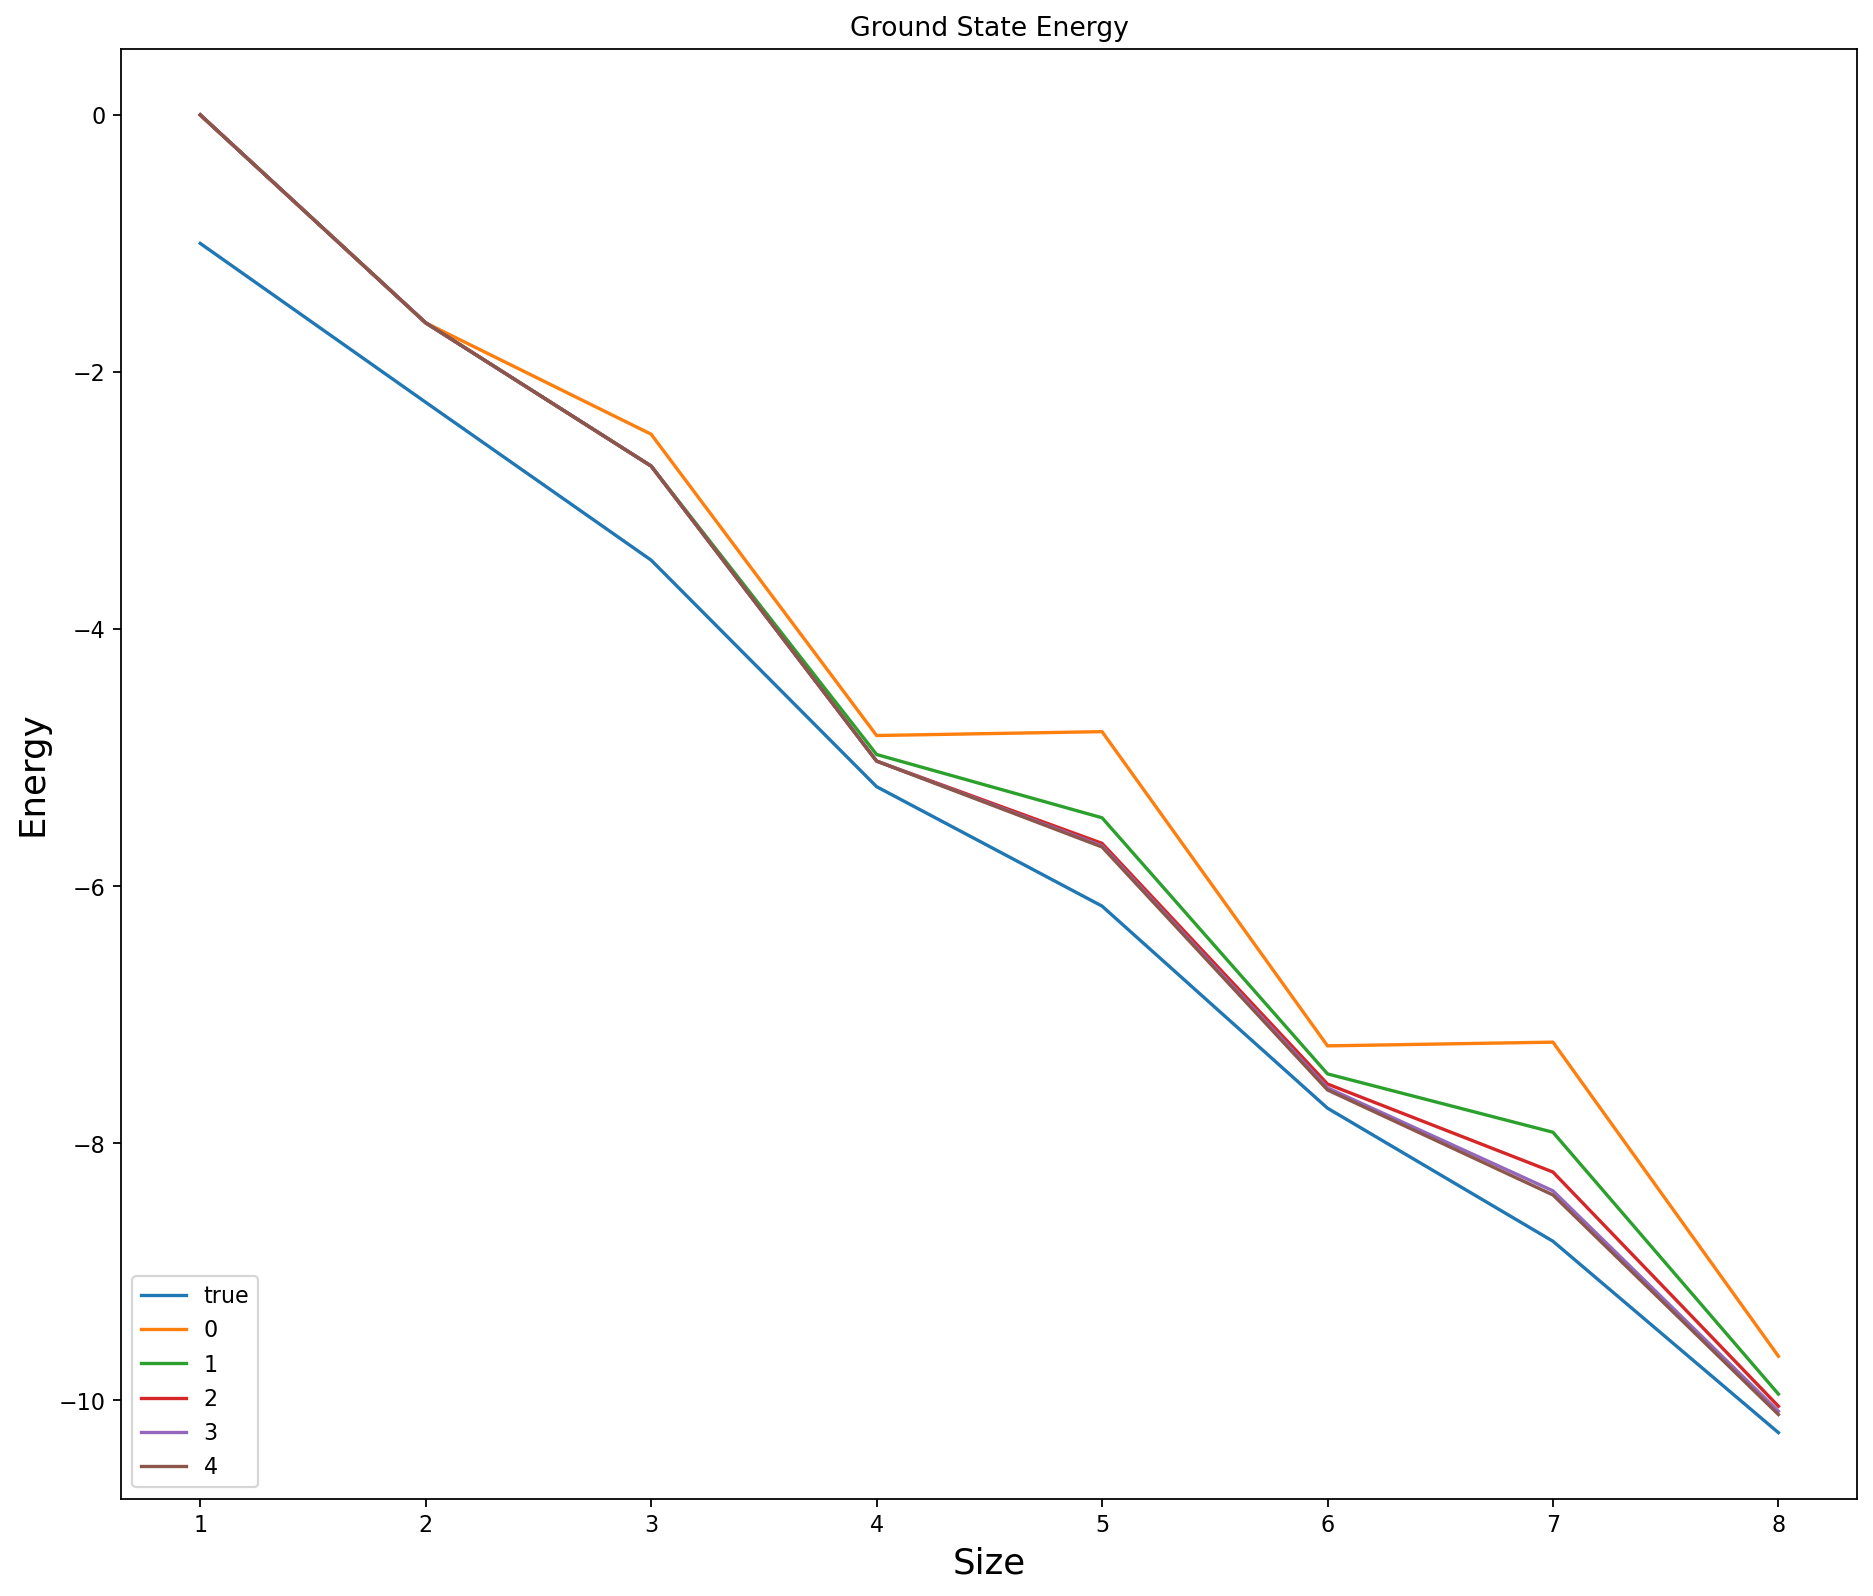

In [21]:
figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, len(trueGroundStates))), np.asarray(np.real(trueGroundStates[1:]), float), label="true")
for i in range(s):
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(i))
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy', size = 16)
pylab.title('Ground State Energy')
pylab.legend(loc='lower left') #more descriptive legend

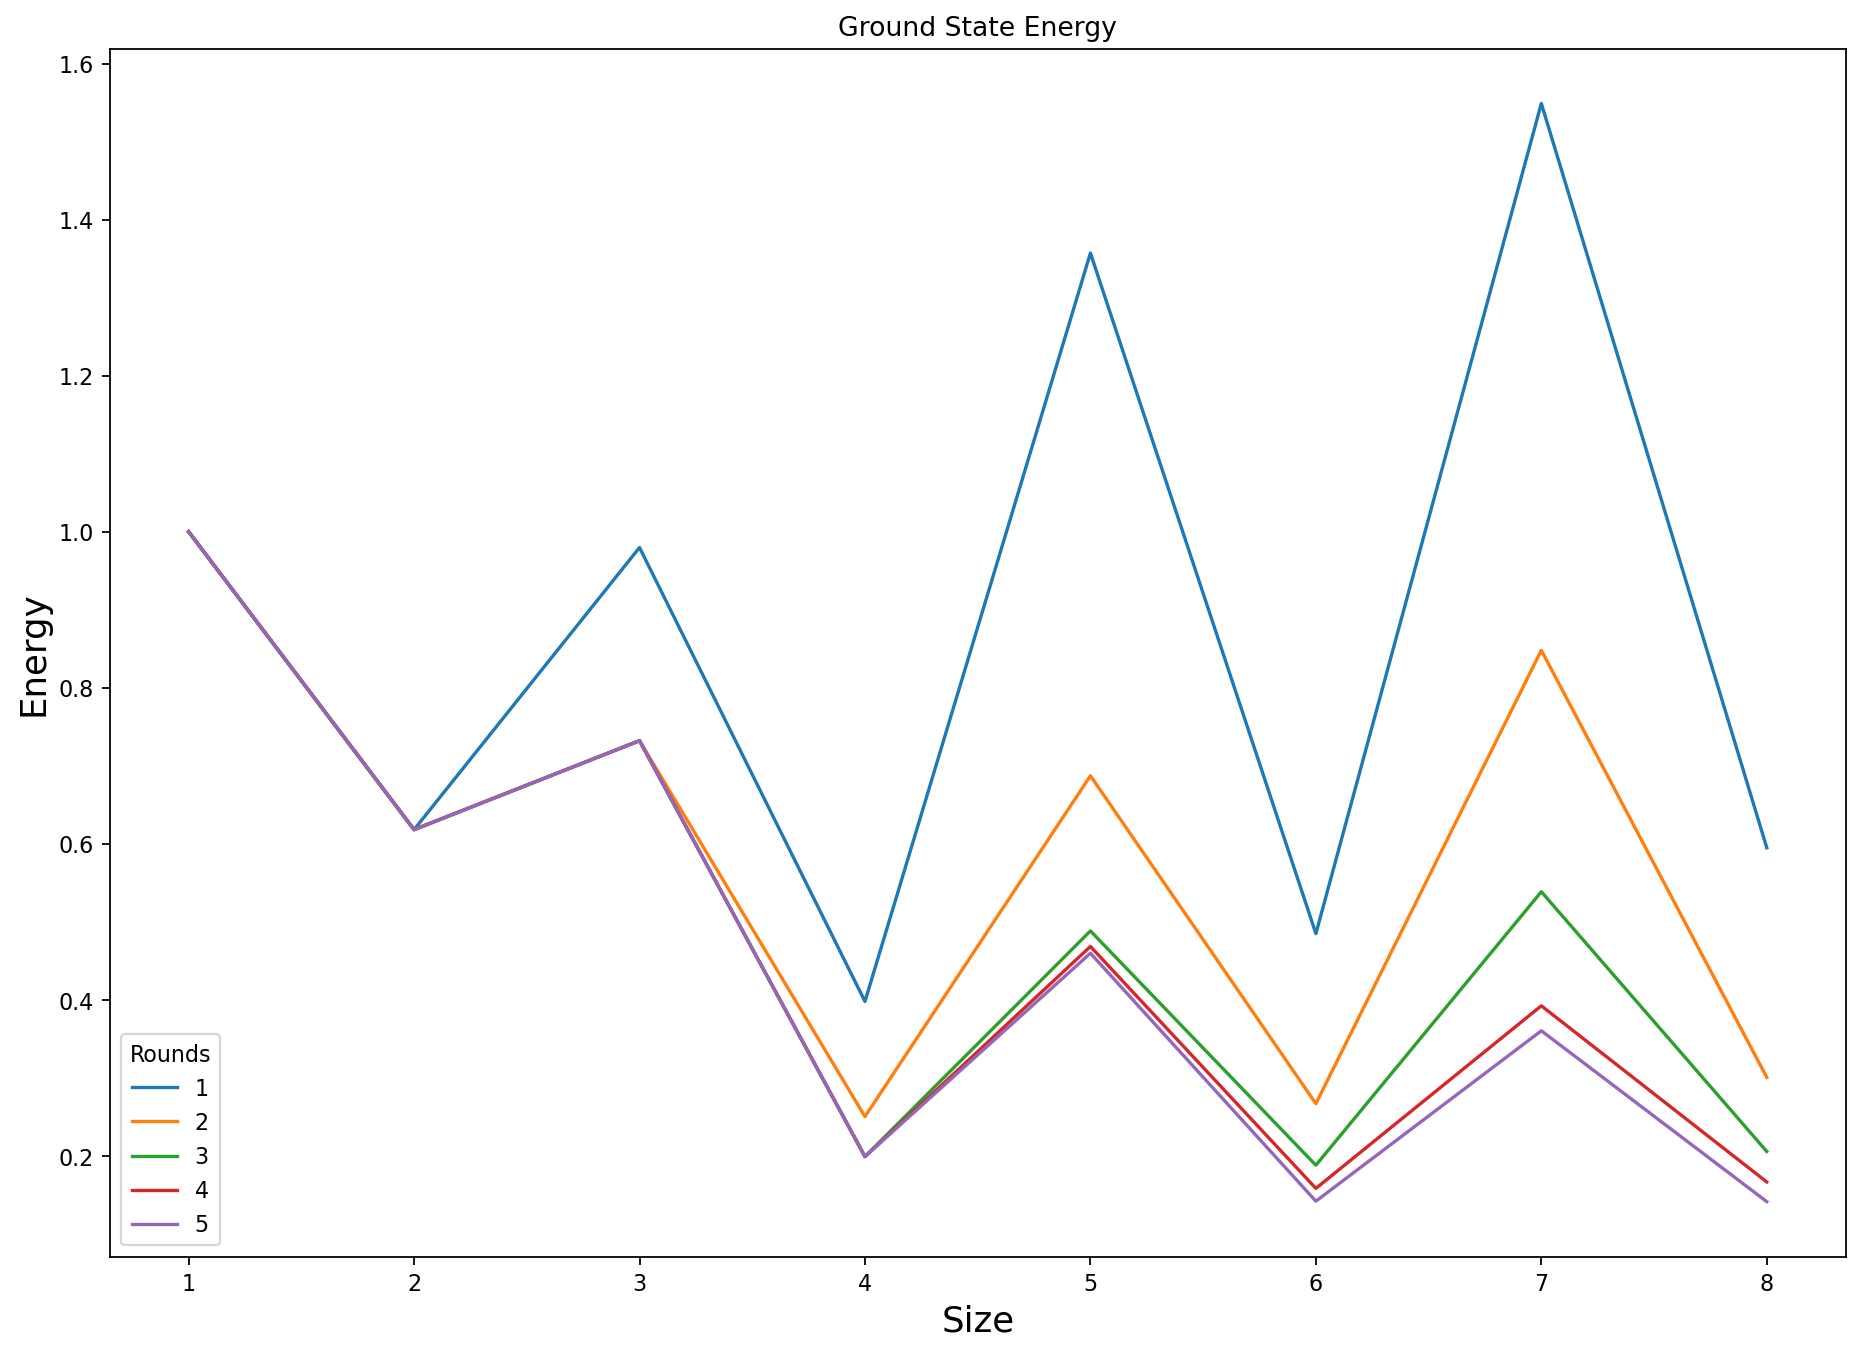

In [29]:
figure(figsize=(14, 10), dpi=160)

for i in range(s):
    diff = np.asarray(np.real(groundStates[i][1:]), float) - np.asarray(np.real(trueGroundStates[1:]), float)
    pylab.plot(list(range(1, len(groundStates[i]))), diff, label=f"{i + 1}")
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy', size = 16)
pylab.title('Ground State Energy')
pylab.legend(loc='lower left', title = 'Rounds') #more descriptive legend
pylab.savefig('plt6.png')

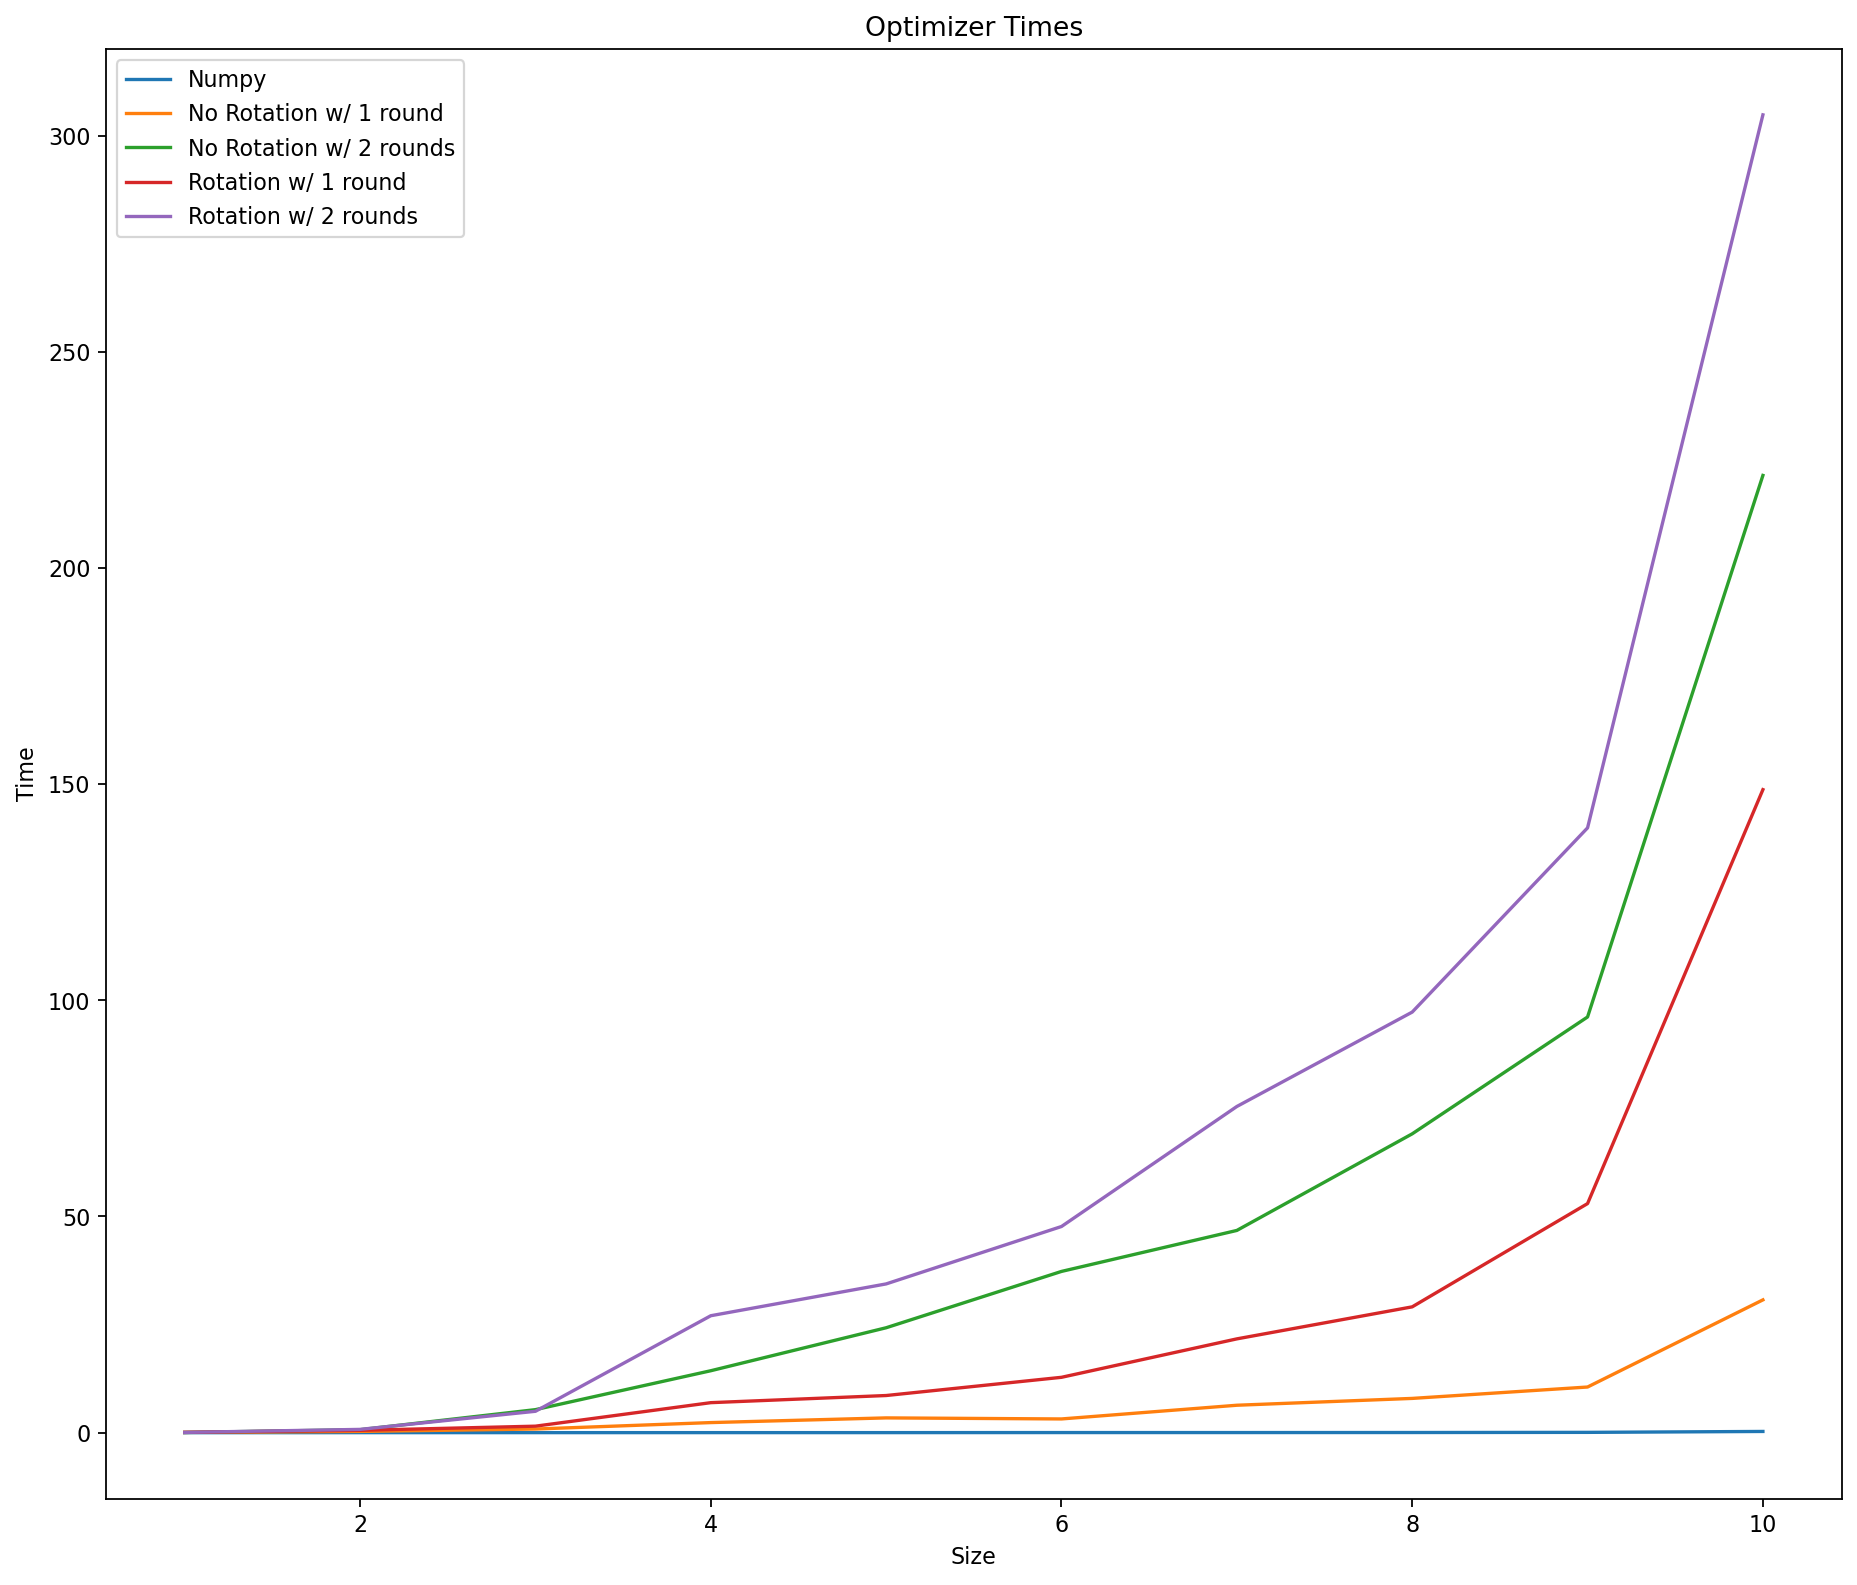

In [24]:
figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, n)),  trueTimes[1:], label='Numpy')
pylab.plot(list(range(1, n)),  np.sum(timesNR[0][1:], axis = 1), label='No Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesNR[1][1:], axis = 1), label='No Rotation w/ 2 rounds')
pylab.plot(list(range(1, n)),  np.sum(timesR[0][1:], axis = 1), label='Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesR[1][1:], axis = 1), label='Rotation w/ 2 rounds')

pylab.xlabel('Size')
pylab.ylabel('Time')
pylab.title('Optimizer Times')
pylab.legend(loc='upper left')

In [7]:
print(groundStates)

[array([ 9.99990000e+03,  0.00000000e+00, -1.61803399e+00, -2.48443528e+00,
       -4.82842712e+00, -4.79829286e+00, -7.24264059e+00, -7.21372027e+00,
       -9.65685402e+00]), array([ 9.99990000e+03,  0.00000000e+00, -1.61803398e+00, -2.73205071e+00,
       -4.97606758e+00, -5.46824443e+00, -7.46060547e+00, -7.91460095e+00,
       -9.95120584e+00]), array([ 9.99990000e+03,  0.00000000e+00, -1.61803398e+00, -2.73205072e+00,
       -5.02732215e+00, -5.66713544e+00, -7.53952141e+00, -8.22410752e+00,
       -1.00461698e+01]), array([ 9.99990000e+03,  0.00000000e+00, -1.61803399e+00, -2.73205079e+00,
       -5.02733896e+00, -5.68706359e+00, -7.56920012e+00, -8.37032418e+00,
       -1.00852364e+01]), array([ 9.99990000e+03,  0.00000000e+00, -1.61803399e+00, -2.73205079e+00,
       -5.02733905e+00, -5.69569497e+00, -7.58560167e+00, -8.40234818e+00,
       -1.01104518e+01])]


In [15]:
print(np.sum(times)/60/60)

2.952271948456764
